In [2]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_bloch_multivector, plot_histogram, array_to_latex
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import Statevector
from numpy import pi
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
import random
import networkx as nx
import matplotlib.pyplot as plt

sim = Aer.get_backend('aer_simulator')

## Change the Parameters (number of ancilla inputs and outputs, control gates etc)
## Don't change variable names

In [3]:
%%file instruction_set.txt             ##RUN IT TO CREATE THE TXT FILE THAT CONTAINS THE CIRCUIT INFO##
inp = QuantumRegister(1,'input')       #input register, change the number of qubits if you want
anc = QuantumRegister(5,'anc_input')   #ancilla input register, change the qubits if you want
cl = ClassicalRegister(5,'anc_output') #classical register for measurement purposes, change the bits if you want
qc = QuantumCircuit(inp,anc,cl)
qc.cx(1,0)
qc.cx(1,2)                             ################################################
qc.cx(3,1)                             # CHANGE THE GATES BUT TRY >1-QUBIT GATES ONLY #
qc.cx(4,2)                             ################################################
qc.cx(3,5)
qc.cx(4,5)
qc.measure([0,1,2,3,4],cl)             #change the qubits that are measured
qc.draw(output='mpl')

UsageError: unrecognized arguments: ##RUN IT TO CREATE THE TXT FILE THAT CONTAINS THE CIRCUIT INFO##


## Draw the Circuit, (any changes from the above cell must be made in this cell also)

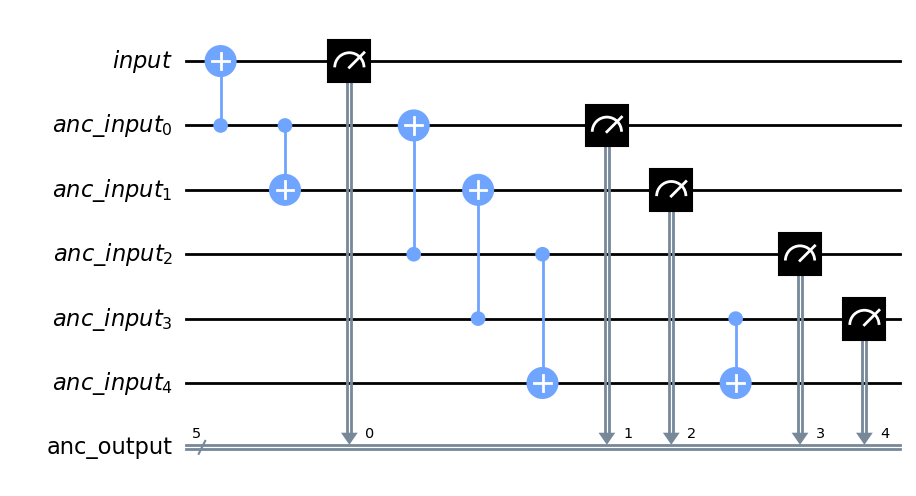

In [240]:
inp = QuantumRegister(1,'input')
anc = QuantumRegister(5,'anc_input')
cl = ClassicalRegister(5,'anc_output')
qc = QuantumCircuit(inp,anc,cl)
qc.cx(1,0)
qc.cx(1,2)
qc.cx(3,1)
qc.cx(4,2)
qc.cx(3,5)
qc.cx(4,5)
qc.measure([0,1,2,3,4],cl)
qc.draw(output='mpl')

## Creating abstarct types (Node, Graph)

In [4]:
class Node:
    def __init__(self, type_str):
        self.label = type_str
        self.point = []
        self.head = None
        self.value = None
    
    def add_point(self, new_pointer):
        self.point.append(new_pointer)
        
    def get_type(self):
        return self.label
    
    def get_head(self):
        if self.head:
            return self.head
        else:
            return False
        
    
    
##########################################    
            
class Graph:
    def __init__(self):
        self.count = 0
        self.q = []
        pass
    
    def connect(self, node_left, node_right):
        if node_left.get_type()[:-1] == 'input' and node_left.get_head():
            node = node_left.head
            node.add_point(node_right)
            node_left.head = node_right
            print(f"{node.get_type()}->{node_right.get_type()}")
        else:
            node_left.add_point(node_right)
            print(f"{node_left.get_type()}->{node_right.get_type()}")
            node_left.head = node_right
            
    def Q(self):
        return self.q
        
    def calculate_cost(self, node):
        self.count = 0
        cost = self.calculate_helper(node)
        return cost
    
    def calculate_helper(self, node):
        for p in node.point:
            if p.get_type()[:-1] == 'output':
                self.count += 1
                if len(p.point)>0:
                    self.calculate_helper(p)
                break

            else:
                self.calculate_helper(p)
                
        return self.count

    
        
    
        

## Reading instruction_set.txt and translates txt file to graph

In [13]:
circ = open('instruction_set.txt', "r")
g = Graph()
i = 0
gate_num = 0
for line in circ:
    if i == 0:
        input_num = int(line[22])
        input_nodes = [Node('input'+str(k)) for k in range(input_num)]
    elif i == 1:
        ancilla_in = int(line[22])
        ancin_nodes = [Node('input'+str(k+input_num)) for k in range(ancilla_in)]
    elif i == 2:
        ancilla_out = int(line[23])
        ancout_nodes = []
    elif i >= 4:
        if line[3] == 'c':
            gate_num += 1
            target = int(line[-3])
            control = int(line[-5])
            target_node = (input_nodes[target] if target < input_num else ancin_nodes[target-input_num])
            control_node = (input_nodes[control] if control < input_num else ancin_nodes[control-input_num])
            gate = Node('gate'+str(i-4 + 1))
            
            g.connect(target_node, gate)
            g.connect(control_node, gate)
            print('=============================')
            
        elif line[3] == 'm':
            indx = -2
            for j in range(ancilla_out):
                out_ind = int(line[-5 + indx])
                out_node = (input_nodes[out_ind] if out_ind < input_num else ancin_nodes[out_ind-input_num])
                output = Node('output'+str(out_ind))
                #out_node.step.append(2)
               
                g.connect(out_node, output)
                indx += -2
          
    i += 1




    

input0->gate1
input1->gate1
input2->gate2
gate1->gate2
gate2->gate3
input3->gate3
gate2->gate4
input4->gate4
input5->gate5
gate3->gate5
gate5->gate6
gate4->gate6
gate6->output4
gate5->output3
gate4->output2
gate3->output1
gate1->output0


## Visualizing Graph that corresponds to the quantum circuit (install graphviz library first)

In [371]:
import graphviz

def add_nodes_edges(node, edges_dict):
    if len(node.point) > 0:
        dot.node(node.point[0].get_type())
        edge = (node.get_type(), node.point[0].get_type())
        if edge not in edges_dict:
            dot.edge(*edge)
            edges_dict.add(edge)
            add_nodes_edges(node.point[0], edges_dict)
        
    if len(node.point) > 1:
        dot.node(node.point[1].get_type())
        edge = (node.get_type(), node.point[1].get_type())
        if edge not in edges_dict:
            dot.edge(*edge)
            edges_dict.add(edge)
            add_nodes_edges(node.point[1], edges_dict)


dot = graphviz.Digraph()
dot.node(input_nodes[0].get_type())
add_nodes_edges(input_nodes[0], set())
if input_num > 1:
    for i in range (input_num):   
        dot.node(input_nodes[i+1].get_type())
        dot.edge(input_nodes[i+1].get_type(), input_nodes[i+1].point[0].get_type())
for i in range (ancilla_in):   
    dot.node(ancin_nodes[i].get_type())
    dot.edge(ancin_nodes[i].get_type(), ancin_nodes[i].point[0].get_type())
dot.render('graph', view=True, format='png')

'graph.png'

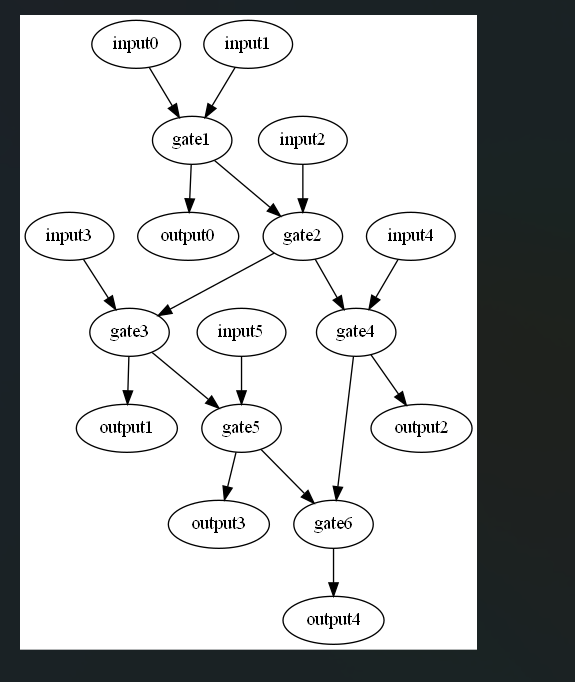

# Algorithm

## Finding which input node has fewer ancilla outputs as successor nodes

In [14]:
node_list = []
for i in range(ancilla_in):
    ancin_nodes[i].value = ancilla_out - g.calculate_cost(ancin_nodes[i])
    node_list.append(ancin_nodes[i])

sorted_nodes = list(reversed(sorted(node_list, key=lambda x: x.value)))
g.q = sorted_nodes
print(' QUEUE')
for k in sorted_nodes:
    print(k.get_type())

 QUEUE
input5
input4
input3
input2
input1


## Functions to run the Algorithm

In [15]:
def output_helper(node, pList):
    for p in node.point:
        if p.get_type()[:-1] == 'output':
            pList.append(p)
            if len(p.point)>0:
                output_helper(p, pList)
            break

        else:
            output_helper(p, pList)

def precending_outputs(node):
    n_list = []
    output_helper(node, n_list)
    pr_list = []
    for x in node_list:
        if node == x:
            continue
        else:
            temp_list = []
            output_helper(x, temp_list)
            difference_result = [item for item in temp_list if item not in n_list]
            break
            
    pr_list = difference_result
                
    #print(pr_list[0].get_type())
    if len(pr_list)<1:
        return False
                
    return pr_list[0]

def new_cost():
    for i in range(len(g.Q())):
        g.Q()[i].value = ancilla_out - g.calculate_cost(g.Q()[i])
        
    sorted_nodes = list(reversed(sorted(g.Q(), key=lambda x: x.value)))
    g.q = sorted_nodes
    

def algorithm():
    for a in g.Q():
        #a = g.Q()[0]
        #print(a.get_type())
        current_node = a
        g.Q().remove(a)
        p_o = precending_outputs(current_node)
        if not p_o:
            break
        node_list.remove(current_node)
        ancin_nodes.remove(current_node)
        g.connect(p_o, current_node)
    
        new_cost()

##############################################################################################        
node_list = []
for i in range(ancilla_in):
    ancin_nodes[i].value = ancilla_out - g.calculate_cost(ancin_nodes[i])
    node_list.append(ancin_nodes[i])

sorted_nodes = list(reversed(sorted(node_list, key=lambda x: x.value)))
g.q = sorted_nodes
       
algorithm()



output1->input5
output2->input3
output0->input2


## First iteration 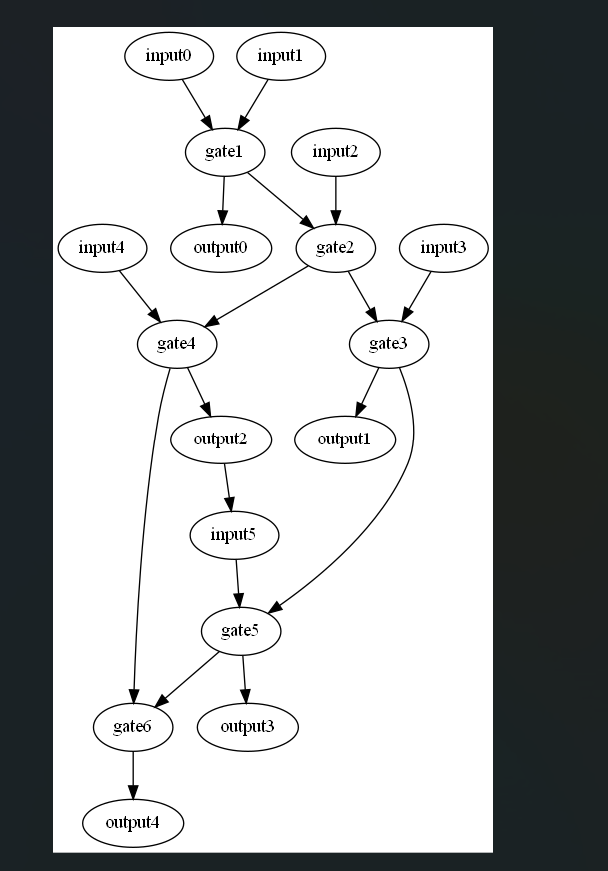

## Visualizing the Result of the Algorithm

In [16]:
import graphviz

def add_nodes_edges(node, edges_dict):
    if len(node.point) > 0:
        dot.node(node.point[0].get_type())
        edge = (node.get_type(), node.point[0].get_type())
        if edge not in edges_dict:
            dot.edge(*edge)
            edges_dict.add(edge)
            add_nodes_edges(node.point[0], edges_dict)
        
    if len(node.point) > 1:
        dot.node(node.point[1].get_type())
        edge = (node.get_type(), node.point[1].get_type())
        if edge not in edges_dict:
            dot.edge(*edge)
            edges_dict.add(edge)
            add_nodes_edges(node.point[1], edges_dict)


dot = graphviz.Digraph()
dot.node(input_nodes[0].get_type())
add_nodes_edges(input_nodes[0], set())
if input_num > 1:
    for i in range (input_num):   
        dot.node(input_nodes[i+1].get_type())
        dot.edge(input_nodes[i+1].get_type(), input_nodes[i+1].point[0].get_type())
for an in ancin_nodes:   
    dot.node(an.get_type())
    dot.edge(an.get_type(), an.point[0].get_type())
dot.render('graph2', view=True, format='png')

'graph2.png'

## Final Optimal Result 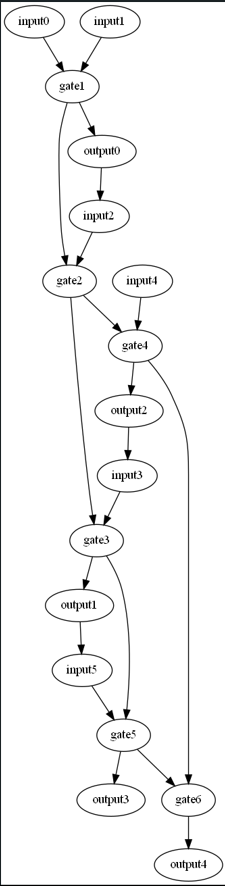